In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm

sns.set_context('paper', font_scale=1.5)
sns.set_palette('colorblind')

import nudetect
H119_dir = '/Volumes/Samsung_1TB/detectorData/H119/'
plot_dir = H119_dir + 'figures/gamma_fulldet_Am241/'
save_dir = H119_dir + 'data_products/'

In [2]:
from astropy.modeling import models, fitting
def tie_stddevs(model):
    return model.stddev_0

def tie_stddevs3(model):
    return model.stddev_3

def tie_means(model):
    return model.mean_0

def tie_means3(model):
    return model.mean_3

def exp_tail(x, norm=1, mean=0, stddev=1, slope=1):
    return norm*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))

def exp_tail_deriv(x, norm=1, mean=0, stddev=1, slope=1):
    return [
        np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*np.sqrt(2*np.pi)) -\
            norm*slope*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*(x-mean)*np.exp(slope*(x-mean) - (x - mean)**2 / stddev**2 * 0.5)/(stddev*stddev*np.sqrt(2*np.pi)),
        norm*(x-mean)*np.exp(slope*(x-mean))*(1-scipy.stats.norm.cdf(x, mean, stddev))
    ]

# ExpTail = models.custom_model(exp_tail, fit_deriv=exp_tail_deriv)
ExpTail = models.custom_model(exp_tail)

def const_shelf(x, norm=1, mean=0, stddev=1):
    return norm*(1-scipy.stats.norm.cdf(x, mean, stddev))

def const_shelf_deriv(x, norm=1, mean=0, stddev=1):
    return [
        (1-scipy.stats.norm.cdf(x, mean, stddev)),
        norm*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev),
        norm*(x-mean)*np.exp(-0.5*(x-mean)**2 / stddev**2) / (np.sqrt(2*np.pi) * stddev**2)
    ]

# ConstShelf = models.custom_model(const_shelf, fit_deriv=const_shelf_deriv)
ConstShelf = models.custom_model(const_shelf)



In [3]:
H119 = nudetect.Detector('H119', offset=np.zeros((32,32,16)))
Am241 = nudetect.Source('Am241')
Am241_flood = nudetect.GammaFlood(H119_dir + 'floodAm241_5C_-500V_20190725_capoffset_corrected.fits',\
                               'H119', Am241, 500, 5, data_dir=save_dir, plot_dir=plot_dir)

Am241_flood = H119.add_experiment(Am241_flood)
H119.print_experiments()


GammaAm2415C500V


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Outliers +/- 1.6464690171951624
Number of outliers: 1


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Gain corrections have not yet been applied to the events. Correcting.
The SUBTH column has not yet been generated. Generating now using thresh=55


  0%|                                                    | 0/32 [00:00<?, ?it/s]/Users/sean/nudetect/nudetect.py:4646: RuntimeWarning: invalid value encountered in double_scalars
  ph_subth_list.append(keV_to_PI(np.sum(np.multiply(np.multiply(ph_subth_mask, pulse_tr_grid), gain_grid))/np.sum(ph_subth_mask)))
/Users/sean/nudetect/nudetect.py:4646: RuntimeWarning: invalid value encountered in multiply
  ph_subth_list.append(keV_to_PI(np.sum(np.multiply(np.multiply(ph_subth_mask, pulse_tr_grid), gain_grid))/np.sum(ph_subth_mask)))
/Users/sean/nudetect/nudetect.py:4648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data_1d['PI'].loc[(row_mask) & (col_mask)] = pi_list
/Users/sean/nudetect/nudetect.py:4649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

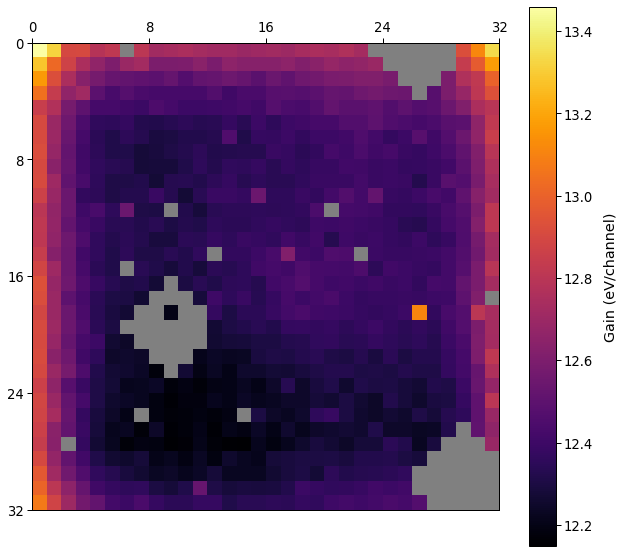

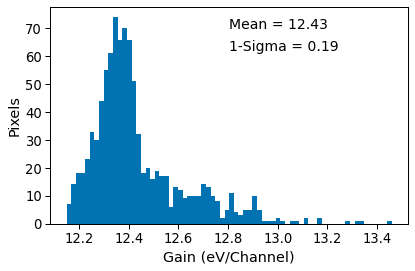

In [4]:
am_gain = Am241_flood.gen_quick_gain(interpolations=0, plt_outlier_threshold=25, fit_below=75)
am_spectrum, am_energies = Am241_flood.gen_spectrum(gain=am_gain, sw_thresh=55, grade_cut=0, exclude_edges=True)

In [5]:
plt.ion()
plt.figure(figsize = (9,6))
plt.plot(am_spectrum[1], am_spectrum[0]/np.max(am_spectrum[0]), label=r'$^{241}\mathrm{Am}$')
plt.xlabel('Energy (keV)')
plt.ylabel('Normalized Counts')
plt.legend()
plt.xlim(0.0,110.)
plt.tight_layout()
plt.savefig(plot_dir + 'Am241_calibrated_spec_offset_grade0_fulldet_noedges.pdf')
plt.close()
# plt.ylim(0,600) 

upper=92.2
lower=91.5

fit_mask = (am_spectrum[1] < upper) & (am_spectrum[1]>lower)

line_init = models.Gaussian1D(amplitude=1000, mean=92., stddev=0.22)

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, am_spectrum[1][fit_mask], am_spectrum[0][fit_mask])

xs = np.linspace(58, 61, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(am_spectrum[1][fit_mask], am_spectrum[0][fit_mask], yerr=np.sqrt(am_spectrum[0][fit_mask]), fmt='', ls='')
ax1.plot(am_spectrum[1][fit_mask], line(am_spectrum[1][fit_mask]))

ax1.set_yscale('log')
ax1.set_ylim((1000, 1000000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')
ax1.text(lower, 8000, r'Source: Pulsar')
ax1.text(lower, 4000, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
# ax1.text(lower, 2000, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')

ax2.errorbar(am_spectrum[1][fit_mask], (am_spectrum[0][fit_mask] - line(am_spectrum[1][fit_mask]))/np.sqrt(am_spectrum[0][fit_mask]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Am241_grade0_60kev_fit_noedges_pulsar_fit.pdf')
plt.close()

print(line.stddev * 2.355 * 1000)

354.42722777118246


In [8]:
x_0 = [4, 14, 8, 21, 20]
y_0 = [4, 12, 23, 5, 23]
rawx = Am241_flood.raw_data_1d['RAWX']
rawy = Am241_flood.raw_data_1d['RAWY']
for i in range(len(x_0)):
    colmask = (rawx >= x_0[i]) & (rawx < (x_0[i] + 5))
    rowmask = (rawy >= y_0[i]) & (rawy < (y_0[i] + 5))
    am_spectrum, am_energies = Am241_flood.gen_spectrum(gain=am_gain, grade_cut=0, misc_mask = colmask & rowmask)
    plt.ion()
    plt.figure(figsize = (9,6))
    plt.plot(am_spectrum[1], am_spectrum[0]/np.max(am_spectrum[0]), label=r'$^{241}\mathrm{Am}$')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Normalized Counts')
    plt.legend()
    plt.xlim(0.0,65.)
    plt.tight_layout()
    plt.savefig(plot_dir + 'Am241_calibrated_spec_offset_grade0_reg_x' + str(x_0[i]) + 'y' + str(y_0[i]) + '.pdf')
    plt.close()
    
    upper=5050
    lower=4700

    line_init = models.Gaussian1D(amplitude=150, mean=59.6, stddev=0.22) + ConstShelf(norm=11, mean=59.5, stddev=0.2) + \
        ExpTail(norm=920, mean=59.5, stddev=0.2, slope=3.7)# + models.Const1D(amplitude=20)

    line_init.stddev_1.tied=tie_stddevs
    line_init.mean_1.tied = tie_means
    line_init.stddev_2.tied=tie_stddevs
    line_init.mean_2.tied = tie_means

    zero_mask = am_spectrum[0][lower:upper]!=0

    fit_line = fitting.LevMarLSQFitter()
    line = fit_line(line_init, am_spectrum[1][lower:upper], am_spectrum[0][lower:upper])

    xs = np.linspace(58, 61, int(1e6))
    spline = UnivariateSpline(xs,
                              line(xs) - line(xs).max()/2)
    roots = spline.roots() # find the roots
    
    fwhm_sample = []
    fake_spec = np.random.poisson(lam=am_spectrum[0][lower:upper], size = (1000, len(am_spectrum[0][lower:upper])))
    for s in tqdm(fake_spec):

        fit_line = fitting.LevMarLSQFitter()
        line = fit_line(line_init, am_spectrum[1][lower:upper], s)

        xs = np.linspace(58, 61, int(1e6))
        spline = UnivariateSpline(xs, line(xs) - line(xs).max()/2)
        # spline = UnivariateSpline(xs, line(xs) - line(xs).max()/2)
        roots = spline.roots() # find the roots

        fwhm_sample.append(roots[1] - roots[0])

    print(np.mean(fwhm_sample))
    print(np.std(fwhm_sample))



    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
    ax1.errorbar(am_spectrum[1][lower:upper], am_spectrum[0][lower:upper], yerr=np.sqrt(am_spectrum[0][lower:upper]), fmt='', ls='')
    ax1.plot(am_spectrum[1][lower:upper], line(am_spectrum[1][lower:upper]))

    ax1.plot(am_spectrum[1][lower:upper], line[0](am_spectrum[1][lower:upper]), ls='dashed')
    ax1.plot(am_spectrum[1][lower:upper], line[1](am_spectrum[1][lower:upper]), ls='dashed')
    ax1.plot(am_spectrum[1][lower:upper], line[2](am_spectrum[1][lower:upper]), ls='dashed')
    ax1.set_yscale('log')
    ax1.set_ylim((1, 2000))
    ax1.set_ylabel('Counts')
    ax1.set_xlabel('Energy (keV)')
    ax1.text(56.6, 1200, r'Source: $^{241}$Am')
    ax1.text(56.6, 700, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
    ax1.text(56.6, 400, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')

    ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),
                 yerr=1.0, fmt='', ls='')
    ax2.axhline(0, color='C1')
    ax2.set_ylim((-5,5))
    ax2.set_xlabel('Energy (keV)')
    ax2.set_ylabel(r'$\chi$')
    plt.savefig(plot_dir + 'Am241_grade0_60kev_fit_noedges_reg_x' + str(x_0[i]) + 'y' + str(y_0[i]) + '.pdf')
    plt.close()
    
    lower=1020
    upper=1250

    line_init = models.Gaussian1D(amplitude=400, mean=13.9, stddev=0.2) + \
        ExpTail(norm=250, mean=13.9, stddev=0.2, slope=3.6) + models.Const1D(amplitude=10)

    line_init.stddev_1.tied=tie_stddevs
    line_init.mean_1.tied = tie_means


    fit_line = fitting.LevMarLSQFitter()
    line = fit_line(line_init, am_spectrum[1][lower:upper], am_spectrum[0][lower:upper])


    xs = np.linspace(10, 15.5, int(1e6))
    spline = UnivariateSpline(xs,
                              line(xs) - line(xs).max()/2 - line.parameters[-1])
    roots = spline.roots() # find the roots
    
    fwhm_sample = []
    fake_spec = np.random.poisson(lam=am_spectrum[0][lower:upper], size = (1000, len(am_spectrum[0][lower:upper])))
    for s in tqdm(fake_spec):

        fit_line = fitting.LevMarLSQFitter()
        line = fit_line(line_init, am_spectrum[1][lower:upper], s)

        xs = np.linspace(10, 15.5, int(1e6))
        spline = UnivariateSpline(xs, line(xs) - line(xs).max()/2 - line.parameters[-1])
        # spline = UnivariateSpline(xs, line(xs) - line(xs).max()/2)
        roots = spline.roots() # find the roots

        fwhm_sample.append(roots[1] - roots[0])

    print(np.mean(fwhm_sample))
    print(np.std(fwhm_sample))


    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
    ax1.errorbar(am_spectrum[1][lower:upper], am_spectrum[0][lower:upper], yerr=np.sqrt(am_spectrum[0][lower:upper]), fmt='', ls='')
    ax1.plot(am_spectrum[1][lower:upper], line(am_spectrum[1][lower:upper]))

    ax1.plot(am_spectrum[1][lower:upper], line[0](am_spectrum[1][lower:upper]), ls='dashed')
    ax1.plot(am_spectrum[1][lower:upper], line[1](am_spectrum[1][lower:upper]), ls='dashed')
    ax1.plot(am_spectrum[1][lower:upper], line[2](am_spectrum[1][lower:upper]), ls='dashed')
    ax1.set_yscale('log')
    ax1.set_ylim((1, 2000))
    ax1.set_ylabel('Counts')
    ax1.set_xlabel('Energy (keV)')
    ax1.text(12.4, 1200, r'Source: $^{241}$Am')
    ax1.text(12.4, 700, 'Centroid = ' + str(round(line.parameters[1], 1)) + ' keV')
    ax1.text(12.4, 400, 'FWHM = ' + str(int(1000*(roots[1] - roots[0]))) + ' eV')

    ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),
                 yerr=1.0, fmt='', ls='')
    ax2.axhline(0, color='C1')
    ax2.set_ylim((-5,5))
    ax2.set_xlabel('Energy (keV)')
    ax2.set_ylabel(r'$\chi$')
    plt.savefig(plot_dir + 'Am241_grade0_14kev_fit_noedges_reg_x' + str(x_0[i]) + 'y' + str(y_0[i]) + '.pdf')
    plt.close()






100%|███████████████████████████████████████| 1000/1000 [35:55<00:00,  2.16s/it]
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_52104/1452173527.py:75: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.6108954366138908
0.003980655385772769


100%|███████████████████████████████████████| 1000/1000 [33:08<00:00,  1.99s/it]


0.45117500937291427
0.005541692820474079


100%|███████████████████████████████████████| 1000/1000 [36:09<00:00,  2.17s/it]
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_52104/1452173527.py:75: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.6334626873173136
0.004512085114139338


100%|█████████████████████████████████████| 1000/1000 [3:18:43<00:00, 11.92s/it]


0.46465001474374656
0.006871042106938348


100%|███████████████████████████████████████| 1000/1000 [36:32<00:00,  2.19s/it]
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_52104/1452173527.py:75: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.6507697491858303
0.004419550219134044


100%|█████████████████████████████████████| 1000/1000 [1:40:32<00:00,  6.03s/it]


0.5143999070675536
0.007100731598682544


100%|███████████████████████████████████████| 1000/1000 [35:27<00:00,  2.13s/it]
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_52104/1452173527.py:75: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.5843441274713084
0.003938503228050083


100%|███████████████████████████████████████| 1000/1000 [28:24<00:00,  1.70s/it]


0.4443880483762746
0.005604032257775477


100%|███████████████████████████████████████| 1000/1000 [31:54<00:00,  1.91s/it]
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_52104/1452173527.py:75: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.6514224289188848
0.005029093435741489


100%|███████████████████████████████████████| 1000/1000 [26:29<00:00,  1.59s/it]


0.4744272317729232
0.006079075283722023


# Am241 59.5keV

/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_5477/4210306125.py:32: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),


0.6356448737716462
[1.38871013e+02 5.95971108e+01 2.21741214e-01 1.18924385e+01
 5.95971108e+01 2.21741214e-01 9.50883490e+02 5.95971108e+01
 2.21741214e-01 3.83552686e+00]
[[ 2.02583920e+03  3.33991354e-01  1.16853480e-01 -1.36658336e+01
  -3.90043127e+03 -8.09452412e+00]
 [ 3.33991354e-01  8.20681588e-05  1.39085529e-05 -3.76560409e-03
  -6.32455413e-01 -1.64597464e-03]
 [ 1.16853480e-01  1.39085529e-05  8.68223971e-06 -6.53523371e-04
  -2.29308309e-01 -4.21053739e-04]
 [-1.36658336e+01 -3.76560409e-03 -6.53523371e-04  7.62990853e-01
   2.53261687e+01  8.00664040e-02]
 [-3.90043127e+03 -6.32455413e-01 -2.29308309e-01  2.53261687e+01
   7.53077531e+03  1.54997066e+01]
 [-8.09452412e+00 -1.64597464e-03 -4.21053739e-04  8.00664040e-02
   1.54997066e+01  3.65119842e-02]]


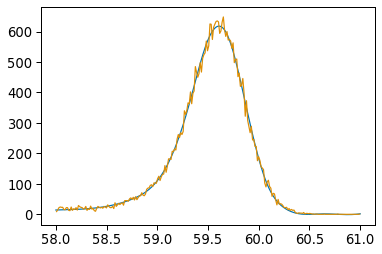

In [27]:
upper=5050
lower=4700

line_init = models.Gaussian1D(amplitude=150, mean=59.6, stddev=0.22) + ConstShelf(norm=11, mean=59.5, stddev=0.2) + \
    ExpTail(norm=920, mean=59.5, stddev=0.2, slope=3.7)# + models.Const1D(amplitude=20)

# line_init = models.Gaussian1D(amplitude=500, mean=59.5, stddev=0.2) + ConstShelf(norm=10, mean=59.5, stddev=0.2)


line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means
line_init.stddev_2.tied=tie_stddevs
line_init.mean_2.tied = tie_means

zero_mask = am_spectrum[0][lower:upper]!=0

fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, am_spectrum[1][lower:upper], am_spectrum[0][lower:upper])

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(am_spectrum[1][lower:upper], am_spectrum[0][lower:upper], yerr=np.sqrt(am_spectrum[0][lower:upper]), fmt='', ls='')
ax1.plot(am_spectrum[1][lower:upper], line(am_spectrum[1][lower:upper]))

ax1.plot(am_spectrum[1][lower:upper], line[0](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[1](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[2](am_spectrum[1][lower:upper]), ls='dashed')
ax1.set_yscale('log')
ax1.set_ylim((1.0, 1000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')

ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Am241_grade0_60kev_fit.pdf')
plt.close()


# chisq_red = np.sum(((am_spectrum[0][lower:upper][zero_mask] - line(am_spectrum[1][lower:upper][zero_mask])) ** 2)/\
#                    am_spectrum[0][lower:upper][zero_mask])/len(am_spectrum[0][lower:upper][zero_mask] - 7)
# print(chisq_red)

xs = np.linspace(58, 61, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(am_spectrum[1][np.abs(am_spectrum[1] - 59.5) < 1.5],
         am_spectrum[0][np.abs(am_spectrum[1] - 59.5) < 1.5])
del xs, spline
print(roots[1] - roots[0])
print(line.parameters)
print(fit_line.fit_info['param_cov'])


# Am241 14keV

1.0965535071406753
0.4790523836114353
[1.24435874e+02 1.39703364e+01 1.78781115e-01 2.49428141e+02
 1.39703364e+01 1.78781115e-01 3.62637484e+00 1.04077155e+01]
[[ 8.43207176e+02  1.96000128e-02  1.40472406e-01 -1.66680271e+03
  -1.18004713e+01 -1.46372285e+01]
 [ 1.96000128e-02  1.51902788e-05 -8.59501839e-07 -3.69287094e-02
  -6.05860463e-04 -1.39932821e-03]
 [ 1.40472406e-01 -8.59501839e-07  2.76840181e-05 -2.80870874e-01
  -1.92685699e-03 -2.65030480e-03]
 [-1.66680271e+03 -3.69287094e-02 -2.80870874e-01  3.30612648e+03
   2.33629933e+01  2.83118726e+01]
 [-1.18004713e+01 -6.05860463e-04 -1.92685699e-03  2.33629933e+01
   1.75915745e-01  2.45071890e-01]
 [-1.46372285e+01 -1.39932821e-03 -2.65030480e-03  2.83118726e+01
   2.45071890e-01  7.84794794e-01]]


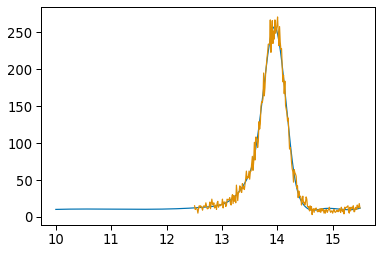

In [30]:
lower=1020
upper=1250

# line_init = models.Gaussian1D(amplitude=250, mean=13.9, stddev=0.3) + ConstShelf(norm=1, mean=13.9, stddev=0.2) + models.Const1D(amplitude=20)

line_init = models.Gaussian1D(amplitude=120, mean=13.9, stddev=0.2) + \
    ExpTail(norm=250, mean=13.9, stddev=0.2, slope=3.6) + models.Const1D(amplitude=10)

line_init.stddev_1.tied=tie_stddevs
line_init.mean_1.tied = tie_means


fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, am_spectrum[1][lower:upper], am_spectrum[0][lower:upper])

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(9,8), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [2,1]})
ax1.errorbar(am_spectrum[1][lower:upper], am_spectrum[0][lower:upper], yerr=np.sqrt(am_spectrum[0][lower:upper]), fmt='', ls='')
ax1.plot(am_spectrum[1][lower:upper], line(am_spectrum[1][lower:upper]))

ax1.plot(am_spectrum[1][lower:upper], line[0](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[1](am_spectrum[1][lower:upper]), ls='dashed')
ax1.plot(am_spectrum[1][lower:upper], line[2](am_spectrum[1][lower:upper]), ls='dashed')
ax1.set_yscale('log')
ax1.set_ylim((1.0, 1000))
ax1.set_ylabel('Counts')
ax1.set_xlabel('Energy (keV)')

ax2.errorbar(am_spectrum[1][lower:upper], (am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper]))/np.sqrt(am_spectrum[0][lower:upper]),
             yerr=1.0, fmt='', ls='')
ax2.axhline(0, color='C1')
ax2.set_ylim((-5,5))
ax2.set_xlabel('Energy (keV)')
ax2.set_ylabel(r'$\chi$')
plt.savefig(plot_dir + 'Am241_grade0_14kev_fit.pdf')
plt.close()

chisq_red = np.sum(((am_spectrum[0][lower:upper] - line(am_spectrum[1][lower:upper])) ** 2)/\
                   am_spectrum[0][lower:upper])/len(am_spectrum[0][lower:upper] - 7)
print(chisq_red)

xs = np.linspace(10, 15.5, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2 - line.parameters[-1])
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2 + line.parameters[-1])
plt.plot(am_spectrum[1][np.abs(am_spectrum[1] - 14) < 1.5],
         am_spectrum[0][np.abs(am_spectrum[1] - 14) < 1.5])
del xs, spline
print(roots[1] - roots[0])
print(line.parameters)
print(fit_line.fit_info['param_cov'])
